# Sampleo de parámetros del modelo VAR

La finalidad del primer sampleo es encontrar los parámetros para el modelo Vectorial Autoregresivo. Si consideramos una serie de tiempo de dimensión $K$, $y_{1},..., y_{T}$ en donde $y_{t}=(y_{1t}, ..., y_{Kt})$ es un vector de dimensión $K$, entonces el modelo VAR$(p)$ queda definido como (Lutkepohl , 2005):

$$y_{t}=\upsilon + A_{1}y_{t-1}+...+A_{p}y_{t-p}+u_{t} \quad (1)$$

En donde $\upsilon=(\upsilon_{1},...,\upsilon_{K})$ es el vector de interceptos ($K\times1$), $A_{i}$ son los coeficientes matriciales ($K\times K$) y finalmente $u_{t}$ es un ruido blanco de covarianza $\Sigma_{u}$, la cual es de dimensión ($K\times K$). En este caso, asumimos el ruido blanco como una normal multivariada de $K$ dimensiones. Además, definimos la matriz $A=(A_{1}, ..., A_{p})$ en base a los coeficientes matriciales $A_{i}$.

De acuerdo a la definición (1), es posible definir la función de log-likelihood correspondiente (Lutkephol, 2005):

$$ -\frac{KT}{2}ln \, 2\pi - \frac{T}{2} ln \, |\Sigma_{u}| - \frac{1}{2} tr \left[ (Y^0 - AX)' \Sigma_{u}^{-1} (Y^0 - AX) \right] \quad (2)$$
$$Y^0 = (y_{1} - \upsilon , ..., y_{T} - \upsilon)$$
$$X = (Y_0, \ldots, Y_{T-1}) $$
$$ Y_t = (y_{t} - \upsilon, \ldots, y_{t-p+1} - \upsilon)' \quad \forall t = 1,\ldots,T $$

donde $T$ corresponde al numero de observaciones, $tr$ corresponde a la traza de la matriz, y las matrices $Y^0,X$ son obtenidas a partir de las observaciones del proceso $y_{t}$ del modelo VAR. De esta forma, y asumiendo una prior uniforme, es posible definir la distribución posterior de los parámetros $A,\Sigma_u$ en base a (2), a partir de la cual podemos obtener muestras por métodos de Markov Chain Monte Carlo (MCMC).

Para capturar la incertidumbre en los parámetros $A,\Sigma_u$, generamos muestras mediante el método de Gibbs Sampling. En específico, se consideran las distribuciones de probabilidad para la matriz $A$ dadas por:

$$p(A_{ijk}|A_{-i-j-k}, \Sigma_{u}, D), \forall i,j,k. 1\leq i \leq p \wedge 1\leq j, k \leq K$$

en donde $i$ representa a un coeficiente en específico de $A_i$ de acuerdo a la eq. (1). Los indices $j, k$ representan una entrada en específico de la matriz coeficiente $A_i$ de dimensión $K\times K$.

Además, para la matriz de covarianza del ruido blanco $\Sigma_{u}$, se considera la distribución de probabilidad dada por:

$$p({\Sigma_{u}}_{ij}|A, {\Sigma_{u}}_{-i-j}, D), \forall i,j. 1 \leq i, j \leq K $$

en donde $i,j$ representa una entrada en específico de la matriz $\Sigma_{u}$. 

Lo anterior, da lugar a una actualización continua de las matrices $A,\Sigma_{u}$, en donde se fijan todas las entradas de las matrices excepto una, la cual es sampleada según alguna distribución $q$ predefinida utilizando Metropolis Hastings. Hasta el momento hemos elegido $q$ ser una normal univariada.

Cabe destacar que para cada sampleo univariado se revisa si es que el nuevo parámetro (en conjunto con los anteriores) cumplen con ciertas restricciones. Para la matriz $A$ se debe cumplir que esta sea estable y $\Sigma_{u}$ debe ser semidefinida positiva (porque se trata de una normal multivariada), por lo tanto, no se acepta el sampleo de un nuevo parámetro hasta que se cumplen estas condiciones.

En la implementación definimos una variable $\theta$ que contiene todos los parámetros correspondientes a las matrices $A$ y $\Sigma_{u}$ en un vector. De esta manera pudimos ir iterando por cada parámetro para ir sampleándolos de manera más simple.

A medida que realizábamos experimentos, nos dimos cuenta que los parámetros sampleados no variaban mucho, por lo que decidimos incluir Simulated Annealing para abarcar un mayor espectro de las funciones de probabilidades condicionales definidas anteriormente.

# Procedimiento del sampleo

Para obtener una distribución de los parámetros del modelo VAR, tuvimos que ocupar varios computadores debido al gran tiempo que demoraba el sampleo. El código utilizado para realizar este procedimiento puede encontrarse en **parameters_generation.py**. La obtención $1000$ muestras demoró alrededor de 8 horas.

Debido a que la toma de muestras demoraba mucho, decidimos realizar muestras de un modelo VAR con $p=1$, es decir, tomando en cuenta solo el tiempo anterior para pronosticar el próximo valor de la velocidad del viento. Sin embargo, es posible extender el modelo desarrollado en este proyecto para un $p$ mayor.

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from forecast import simulate_traj, process_traj
from utils import curve_fit, PL5, power_curve, load_data

In [3]:
# Load generated samples.
SAMPLES_PATH = '/home/chrisams/Documents/datasets/data_TAIM/samples_1_1000.pickle'
with open(SAMPLES_PATH, 'rb') as f:
    samples = pickle.load(f)

A_samples = [None] * len(samples)
U_samples = [None] * len(samples)

for i in range(len(samples)):
    A_samples[i] = samples[i][0]
    U_samples[i] = samples[i][1]

# File names used to sample.
PLANT_NAMES = [
    'd05b_2010-06-19_2018-03-05.csv',
    'd01_2009-07-12_2018-01-17.csv',
]

# Load stats (mean and std of files).
STATS_PATH = '/home/chrisams/Documents/datasets/data_TAIM/stats.pickle'
with open(STATS_PATH, 'rb') as f:
    stats = pickle.load(f)

# Gráfica de la curva de potencia

El siguiente código busca los parámetros de una curva de potencia que se adaptan a los datos de potencia generada según la velocidad del viento (medidos experimentalmente).

In [4]:
POWER_DATA_PATH = '/home/chrisams/Documents/datasets/data_TAIM/data_power.csv'

power_data_csv = pd.read_csv(POWER_DATA_PATH) # Speed-PowerGeneration data.
xdata = power_data_csv['Wind speed (m/s)'].values
ydata = power_data_csv['Power (kW)'].values

fit_out = curve_fit(PL5, xdata, ydata, maxfev=10000)

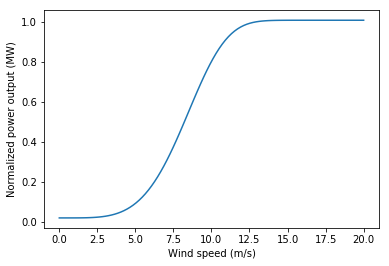

In [5]:
# Plot of the power curve obtained.
u = np.linspace(0.01,20,num=100)
a = fit_out[0][0]
b = fit_out[0][1]
c = fit_out[0][2]
d = fit_out[0][3]
g = fit_out[0][4]
plt_out = PL5(u,a,b,c,d,g)
plt.plot(u,plt_out)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Normalized power output (MW)')
plt.show()

# Predicción de la potencia generada

En la entrega anterior detallamos los pasos que se hacían para llegar a predecir la potencia generada, sin embargo, ahora todo está contenido en el siguiente código.

La generación de los pronósticos consiste en, primero, elegir la cantidad de intervalos de tiempo (en este caso el tamaño del intervalo corresponde a $10$ minutos) durante los cuales se realizará el pronóstico (determinado por la variable **n_data**). Luego, se utiliza el primer dato real para obtener una predicción en un horizonte definido por la variable **horizon**, luego, se utiliza el segundo dato para obtener un segundo pronóstico en el mismo horizonte. Así se repite hasta llegar a los **n_data** pronósticos.

Con esto habremos obtenido distintos tipos de pronósticos. Uno que, dado el tiempo inicial, predice el tiempo inmediatamente siguiente, luego, obtiene el dato real del intervalo siguiente para predecir la potencia generada en el siguiente intervalo, y así sucesivamente, siempre actualizándose con el dato real y prediciendo el tiempo siguiente.

También se obtiene un pronóstico que predice dos intervalos de tiempo en el futuro en vez de uno como el anterior (también retroalimentándose a medida que avanza en el tiempo). Este pronóstico tendrá mayor incerteza y menor precisión.

De esta manera, se pueden obtener pronósticos que predicen hasta una cantidad **horizon** de intervalos de tiempo más adelante del tiempo actual avanzando en **n_data** tiempo, los cuales compararemos a continuación.


## Experimentos con mismo dataset de sampleo

Como primer experimento se considerará los datos de los meses sobre los que se samplearon los parámetros (2011-05 y 2011-06), para observar si estos tienen sentido y se ajustan realmente a los datos reales:

In [35]:
# Simulation of wind speed

horizon = 6 * 3    # How many steps-ahead the forecast are made.
n_samples = 1000  # How many forecast/trajectories are generated for EACH sampled VAR parameter
n_rnd_param = len(samples) 
cap_wind = 3 # Wind plant capacity (eg. 3MW)
cut_speed = 20 # Speed where generator stop working for security.

# Standard deviation and mean to restore original data values of the wind speed.
offset_0 = np.array([stats[PLANT_NAMES[0]]['mean'],stats[PLANT_NAMES[1]]['mean']])
offset_1 = offset_0[:,None,None] #(3,) -> (3,1,1)
std_a = np.array([stats[PLANT_NAMES[0]]['std'],stats[PLANT_NAMES[1]]['std']])
std = std_a[:, None, None]

# Confidence level.
ql = 5
qu = 95

n_data = 10 # Number of hours in which forecasts are made (different from horizon).

# Load real data.
DATA_PATH = '/home/chrisams/Documents/datasets/data_TAIM/processed/'
date_start = '2011-05'
date_end = '2011-06'
n_plants = None
x_data, X = load_data(DATA_PATH, n_plants, 0, resample_rule='10T', n_rows=None,\
                  date_start=date_start, date_end=date_end, plant_names=PLANT_NAMES)

# Real total generation from data
wind_data = x_data * std_a[:, None] + offset_0[:,None] # Restore original wind speed values.
pow_data = power_curve(wind_data,cap_wind,cut_speed,a,b,c,d,g) # Apply power curve.
gen_data = np.sum(pow_data,axis=0) # Sum for all wind farms.

# Forecasts
mean_t = np.zeros((n_data,horizon)) # Mean
ql_t = np.zeros((n_data,horizon)) # Lower quantile
qu_t = np.zeros((n_data,horizon)) # Upper quantile

# Generation of forecasts
for t in range(n_data):
    # Get previous point from which forecast is made
    x0 = x_data[:,t]
    x0 = x0[:,None]
    
    # Make forecast
    sampl_traj = simulate_traj(A_samples,U_samples,x0,offset_1, std, n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
    list_mix = process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,False)
    mean_t[t,:] = list_mix[0]
    ql_t[t,:] = list_mix[1]
    qu_t[t,:] = list_mix[2]

Reading d05b_2010-06-19_2018-03-05.csv...
Reading d01_2009-07-12_2018-01-17.csv...


/home/chrisams/repos/TAIM/utils.py:442: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


In [82]:
# Evaluation metrics.
def mse(real_data, predicted_mean):
    total = 0
    for i in range(len(predicted_mean)):
        total += (real_data[i] - predicted_mean[i]) ** 2
    return total / len(predicted_mean)

def coverage(lower_quantiles, upper_quantiles, predicted_data):
    n_cover = 0
    for i in range(len(predicted_data)):
        if lower_quantiles[i] <= predicted_data[i] <= upper_quantiles[i]:
            n_cover += 1
    return n_cover / len(predicted_data)

def plot_forecast(gen_data, mean_t, ql_t, qu_t, n_data, n, title):
    plt.figure(figsize=(15, 5))
    plt.plot(range(n_data + n),gen_data[:n_data + n],color='green', label='Real generation') #'real' generation'
    plt.plot(range(n,n_data + n),mean_t[:,n - 1],color='blue', label='Mean forecast') #mean forecast
    plt.plot(range(n,n_data + n),ql_t[:,n-1],color='red', label='Confidence interval') #interval forecast
    plt.plot(range(n,n_data + n),qu_t[:,n-1],color='red') 
    plt.xlabel('Time')
    plt.ylabel('Power')
    plt.title(title)
    plt.legend()
    plt.show()

El siguiente gráfico muestra el resultado de pronósticos de un intervalo de tiempo en el futuro. Podemos ver que efectivamente los parámetros obtenidos en el muestreo generan un modelo que se comporta similar a los datos reales. De hecho, como solo se predice un intervalo de tiempo más adelante, los intervalos de confianza no son muy amplios y el valor promedio de la predicción de la potencia generada se acerca mucho a la real.

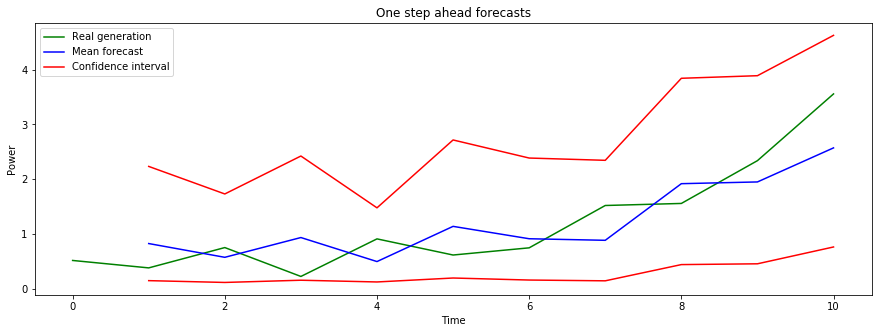

In [46]:
n = 1
title = 'One step ahead forecasts'
plot_forecast(gen_data, mean_t, ql_t, qu_t, n_data, 1, title)

In [53]:
mse_1 = mse(gen_data[1:n_data], mean_t[:-1, 0])
coverage_1 = coverage(ql_t[:-1, 0], qu_t[:-1, 0], gen_data[1:n_data])
print('MSE: {}'.format(mse_1))
print('Coverage: {}'.format(coverage_1))

MSE: 0.2105751714559962
Coverage: 1.0


Las observaciones del gráfico las podemos confirmar con las métricas obtenidas, en donde el MSE es muy bajo y el intervalo de confianza contiene al 100% de los datos.

Ahora veamos lo que ocurre con pronósticos dos tiempos en el futuro:

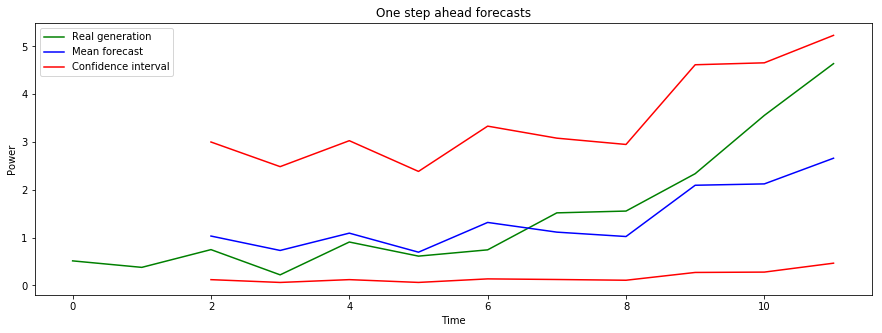

In [48]:
n = 2
title = 'Two steps ahead forecasts'
plot_forecast(gen_data, mean_t, ql_t, qu_t, n_data, 1, title)

Con el gráfico podemos observar que ahora el intervalo de confianza es más amplio, es decir, hay una mayor incerteza. Esto tiene sentido debido a que el modelo solo mira un tiempo atrás para realizar la predicciṕn, por lo que mientras más lejos esté la predicción, mayor será su incerteza. Esto lo podemos corroborar con las métricas de desempeño de la predicción más abajo:

In [55]:
mse_2 = mse(gen_data[n:n_data + n], mean_t[:, n-1])
coverage_2 = coverage(ql_t[:, n-1], qu_t[:, n-1], gen_data[n:n_data + n])
print('MSE: {}'.format(mse_2))
print('Coverage: {}'.format(coverage_2))

MSE: 0.7184822341287144
Coverage: 1.0


Si observamos las métricas de los pronósticos que miran un intervalo de tiempo más grande en el futuro, podemos ver que efectivamente a medida que se quieren hacer pronósticos más alejados, el error cuadrático medio crece e incluso hay predicciones fuera del 95% de confianza.

In [58]:
for i in range(3, 11):
    mse_t = mse(gen_data[i:n_data + i], mean_t[:, i-1])
    coverage_t = coverage(ql_t[:, i-1], qu_t[:, i-1], gen_data[i:n_data + i])
    print('MSE: {}'.format(mse_t))
    print('Coverage: {}'.format(coverage_t))
    print('-' * 20)

MSE: 1.6322936094840617
Coverage: 1.0
--------------------
MSE: 2.7887509162864594
Coverage: 1.0
--------------------
MSE: 4.112072477120715
Coverage: 0.9
--------------------
MSE: 5.542833467772088
Coverage: 0.9
--------------------
MSE: 6.924689661093586
Coverage: 0.9
--------------------
MSE: 8.365575733392138
Coverage: 0.9
--------------------
MSE: 9.77569132788372
Coverage: 0.9
--------------------
MSE: 11.150393424743367
Coverage: 0.8
--------------------


## Experimentos con los días siguientes a los meses sampleados

En este caso se ocuparán los días siguientes a los que se usaron para samplear los parámetros del modelo, es decir, 2011-07:

In [75]:
date_start = '2011-07'
date_end = '2011-07'
n_plants = None
x_data, X = load_data(DATA_PATH, n_plants, 0, resample_rule='10T', n_rows=None,\
                        date_start=date_start, date_end=date_end, plant_names=PLANT_NAMES)

# Real total generation from data
wind_data = x_data * std_a[:, None] + offset_0[:,None] # Restore original wind speed values.
pow_data = power_curve(wind_data,cap_wind,cut_speed,a,b,c,d,g) # Apply power curve.
gen_data = np.sum(pow_data,axis=0) # Sum for all wind farms.

# Forecasts
mean_t = np.zeros((n_data,horizon)) # Mean
ql_t = np.zeros((n_data,horizon)) # Lower quantile
qu_t = np.zeros((n_data,horizon)) # Upper quantile

# Generation of forecasts
for t in range(n_data):
    # Get previous point from which forecast is made
    x0 = x_data[:,t]
    x0 = x0[:,None]
    
    # Make forecast
    sampl_traj = simulate_traj(A_samples,U_samples,x0,offset_1, std, n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
    list_mix = process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,False)
    mean_t[t,:] = list_mix[0]
    ql_t[t,:] = list_mix[1]
    qu_t[t,:] = list_mix[2]

Reading d05b_2010-06-19_2018-03-05.csv...
Reading d01_2009-07-12_2018-01-17.csv...


/home/chrisams/repos/TAIM/utils.py:442: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


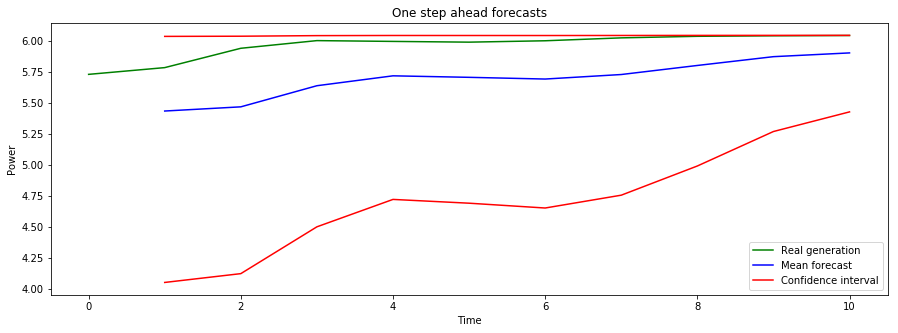

In [83]:
title = 'One step ahead forecasts'
plot_forecast(gen_data, mean_t, ql_t, qu_t, n_data, 1, title)

A simple vista pareciera que el pronóstico no es tan acertada, sin embargo, si vemos las métricas más abajo, podemos ver que el error cuadrático medio es muy bajo y que todas las predicciones se encuentran dentro del intervalo de confianza, por lo que las podríamos concluir que el modelo ajustado con los dos meses anteriores podrían ser usados para predecir los primeros intervalos de tiempo del próximo mes, pero considerando pronósticos un paso adelante.

In [79]:
n = 1
mse_3 = mse(gen_data[n:n_data + n], mean_t[:, n-1])
coverage_3 = coverage(ql_t[:, n-1], qu_t[:, n-1], gen_data[n:n_data + n])
print('MSE: {}'.format(mse_3))
print('Coverage: {}'.format(coverage_3))

MSE: 0.09205055353979394
Coverage: 1.0


Podemos ver cómo se comporta a medida que aumentamos el horizonte de los pronósticos:

In [86]:
for i in range(2, 11):
    mse_t = mse(gen_data[i:n_data + i], mean_t[:, i-1])
    coverage_t = coverage(ql_t[:, i-1], qu_t[:, i-1], gen_data[i:n_data + i])
    print('MSE: {}'.format(mse_t))
    print('Coverage: {}'.format(coverage_t))
    print('-' * 20)

MSE: 0.30574968279527776
Coverage: 1.0
--------------------
MSE: 0.5791417382002773
Coverage: 1.0
--------------------
MSE: 0.8826243631265301
Coverage: 1.0
--------------------
MSE: 1.2090099741841827
Coverage: 1.0
--------------------
MSE: 1.5473794567248755
Coverage: 1.0
--------------------
MSE: 1.8792423410998407
Coverage: 1.0
--------------------
MSE: 2.190806363189712
Coverage: 1.0
--------------------
MSE: 2.483880453128969
Coverage: 1.0
--------------------
MSE: 2.765978870241399
Coverage: 1.0
--------------------


Sorprendentemente pareciera ser que los pronósticos, aunque sean en un horizonte mayor, no disminuyen tanto su calidad. De hecho, todos quedan dentro del intervalo de confianza lo que es un muy buen indicador.

## Experimentos con los mismos meses ocupados para samplear pero distinto año.

En este caso se ocupó un día de junio de 2012 (los parámetros fueron sampleados con datos de mayo y junio de 2011) para analizar el desempeño del modelo.

In [87]:
date_start = '2012-06-15'
date_end = '2012-06-16'
n_plants = None
x_data, X = load_data(DATA_PATH, n_plants, 0, resample_rule='10T', n_rows=None,\
                        date_start=date_start, date_end=date_end, plant_names=PLANT_NAMES)

# Real total generation from data
wind_data = x_data * std_a[:, None] + offset_0[:,None] # Restore original wind speed values.
pow_data = power_curve(wind_data,cap_wind,cut_speed,a,b,c,d,g) # Apply power curve.
gen_data = np.sum(pow_data,axis=0) # Sum for all wind farms.

# Forecasts
mean_t = np.zeros((n_data,horizon)) # Mean
ql_t = np.zeros((n_data,horizon)) # Lower quantile
qu_t = np.zeros((n_data,horizon)) # Upper quantile

# Generation of forecasts
for t in range(n_data):
    # Get previous point from which forecast is made
    x0 = x_data[:,t]
    x0 = x0[:,None]
    
    # Make forecast
    sampl_traj = simulate_traj(A_samples,U_samples,x0,offset_1, std, n_samples,horizon,n_rnd_param,cap_wind,cut_speed, a, b, c, d, g)
    list_mix = process_traj(sampl_traj,ql,qu,n_samples,n_rnd_param,horizon,False)
    mean_t[t,:] = list_mix[0]
    ql_t[t,:] = list_mix[1]
    qu_t[t,:] = list_mix[2]

Reading d05b_2010-06-19_2018-03-05.csv...
Reading d01_2009-07-12_2018-01-17.csv...


/home/chrisams/repos/TAIM/utils.py:442: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(np.zeros(Kv),CovU,size=n_samples)


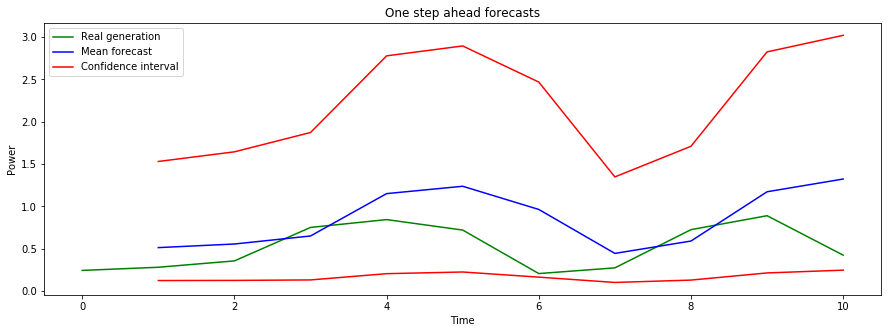

In [88]:
title = 'One step ahead forecasts'
plot_forecast(gen_data, mean_t, ql_t, qu_t, n_data, 1, title)

Del gráfico podemos observar que el modelo se ajusta bastante bien a los datos reales a pesar de que se trata de un año diferente, por lo que nuevamente se demuestra la calidad del modelo generado. De hecho, las métricas obtenidas fueron las siguientes:

In [89]:
n = 1
mse_4 = mse(gen_data[n:n_data + n], mean_t[:, n-1])
coverage_4 = coverage(ql_t[:, n-1], qu_t[:, n-1], gen_data[n:n_data + n])
print('MSE: {}'.format(mse_4))
print('Coverage: {}'.format(coverage_4))

MSE: 0.19796215144680596
Coverage: 1.0


Podemos también analizar qué pasa cuando se aumenta el horizonte de los pronósticos:

In [92]:
for i in range(2, 11):
    mse_t = mse(gen_data[i:n_data + i], mean_t[:, i-1])
    coverage_t = coverage(ql_t[:, i-1], qu_t[:, i-1], gen_data[i:n_data + i])
    print('MSE: {}'.format(mse_t))
    print('Coverage: {}'.format(coverage_t))
    print('-' * 20)

MSE: 0.5353030237123575
Coverage: 1.0
--------------------
MSE: 0.704991764919985
Coverage: 1.0
--------------------
MSE: 0.6327164554741701
Coverage: 1.0
--------------------
MSE: 0.6198565435076884
Coverage: 1.0
--------------------
MSE: 0.7667641922080376
Coverage: 1.0
--------------------
MSE: 0.8623977577278532
Coverage: 1.0
--------------------
MSE: 0.7863432870364693
Coverage: 1.0
--------------------
MSE: 0.6435210225073202
Coverage: 1.0
--------------------
MSE: 0.4996011428494908
Coverage: 1.0
--------------------


En este caso podemos ver que el error cuadrático medio se mantiene bastante estable a pesar de que se aumente el horizonte de tiempo de los pronósticos, por lo que nuevamente habla muy bien del modelo. Resulta peculiar que con los mismos datos con los que se samplearon los parámetros, a medida que se aumentaba el horizonte, el arror cuadrático medio aumentaba mucho más. Sin embargo, el fenómeno anterior es casualidad, debido a que si observamos el gráfico de los pronósticos 9 steps adelante, podemos observar que la varianza es muy alta (intervalos de confianza muy separados entre sí) y que casualmente los datos reales quedaron cerca de los datos generados, de hecho, se ve una tendencia a alejarse de estos en los tiempos que no se consideraron, por lo que las métricas pueden ser engañadoras.

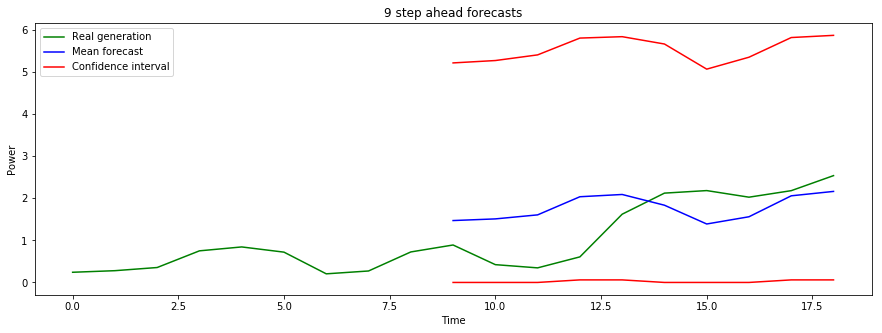

In [94]:
title = '9 step ahead forecasts'
plot_forecast(gen_data, mean_t, ql_t, qu_t, n_data, 9, title)

# Trabajo futuro

A pesar de que el modelo mostrado en los experimentos anteriores es uno que mira solo un tiempo atrás para realizar la predicción y solo incorpora 2 centrales eólicas, el código se hizo general, de manera de poder experimentar con un modelo VAR que pueda considerar $p$ velocidades de viento anteriores para realizar la predicción y considerando $K$ centrales eléctricas, es decir, tiene el potencial de poder generar modelos bastante complejos que otorguen un mejor pronóstico, sin embargo, por limitaciones de tiempo, ya que para probar modelos complejos se necesitaba mayor poder de cómputo, se presentó un modelo simple pero que sirve para ilustrar la funcionalidad de nuestro modelo.

Es por esto que como trabajo futuro se podría analizar el comportamiento de este modelo al complejizarlo más. Además, podrían incorporarse métricas de comparación que incluyan los costos de operación de las centrales.

Finalmente, es importante destacar el poder que tienen los métodos de Monte Carlo para el sampleo de parámetros. Con una cantidad no muy grande de muestras, se pudo lograr un acertado modleo VAR para la predicción de la generación de potencia eólica. Sin embargo, estos métodos toman tiempo, lo cual podría ser una gran limitante a la hora de introducirlos en problemas reales.